In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Setup 
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Load Data 
df = pd.read_csv("../data/processed/qm9_mordred_clean.csv")

In [4]:
# Separate metadata/targets from descriptors
meta_cols = ["smiles", "mu", "HOMO", "LUMO", "gap"]
desc_cols = [col for col in df.columns if col not in meta_cols]

X = df[desc_cols].copy()
y = df["mu"]

In [5]:
# Descriptor Distribution Stats 
print("Number of descriptor features:", len(desc_cols))
print("Descriptor stats:")
display(X.describe())

Number of descriptor features: 31
Descriptor stats:


,alpha,RadiusOfGyration,Asphericity,Eccentricity,PMI1,PMI2,SpherocityIndex,NPR2,SpAbs_A,SpMax_A,...,nBondsM,nBondsKD,C1SP1,C2SP1,C1SP2,C2SP2,C1SP3,C2SP3,HybRatio,FCSP3
count,128757.000000,128757.000000,128757.000000,128757.000000,1.287570e+05,128757.000000,1.287570e+05,128757.000000,128757.000000,128757.000000,...,128757.000000,128757.000000,128757.000000,128757.000000,128757.000000,128757.000000,128757.000000,128757.000000,128757.000000,128757.000000
mean,75.277929,1.968345,0.333208,0.925018,1.344453e+02,341.082160,2.139435e-01,0.809834,10.898900,2.431740,...,1.928447,1.061255,0.243412,0.189955,0.546339,0.547962,1.411807,1.883758,0.744018,0.691975
std,8.188153,0.224401,0.168311,0.061573,4.097083e+01,120.382705,1.633494e-01,0.103150,0.950276,0.235778,...,2.104009,1.008537,0.478759,0.537021,0.783356,0.914445,1.094262,1.430424,0.281927,0.276025
min,13.210000,0.000000,0.000000,0.000000,-3.289165e-16,0.000000,-6.393559e-16,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.459999,1.823747,0.206356,0.896568,1.056483e+02,259.262265,8.520134e-02,0.735106,10.462302,2.246980,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.600000,0.500000
50%,75.610001,1.942305,0.309442,0.940772,1.333897e+02,315.883733,1.927720e-01,0.818335,11.003511,2.414214,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.833333,0.750000
75%,80.620003,2.080096,0.440719,0.969591,1.614037e+02,394.779666,3.115965e-01,0.892445,11.468637,2.612619,...,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000,1.000000,0.857143
max,196.619995,3.418685,1.000000,1.000000,3.258132e+02,1286.724957,1.000000e+00,1.000000,13.875004,3.170086,...,10.000000,4.000000,4.000000,7.000000,6.000000,8.000000,6.000000,9.000000,1.000000,1.000000


In [6]:
# PCA (Dimensionality Reduction)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["mu"] = y

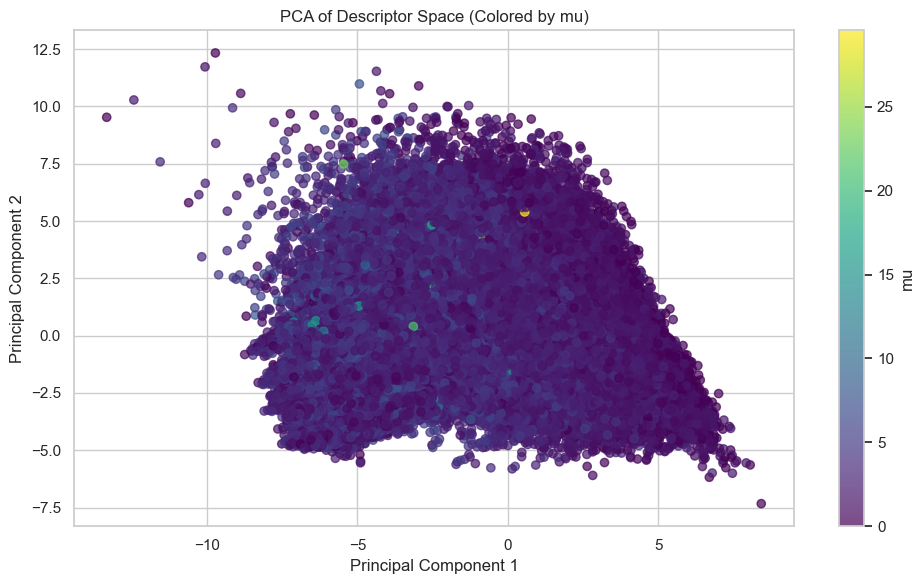

In [9]:
output_dir = "../results/plots"
output_path = f"{output_dir}/pca_descriptor_space_colored_by_mu.png"

# Plot PCA Colored by mu
plt.figure()
sc = plt.scatter(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    c=pca_df["mu"],
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(sc, label="mu")
plt.title("PCA of Descriptor Space (Colored by mu)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()


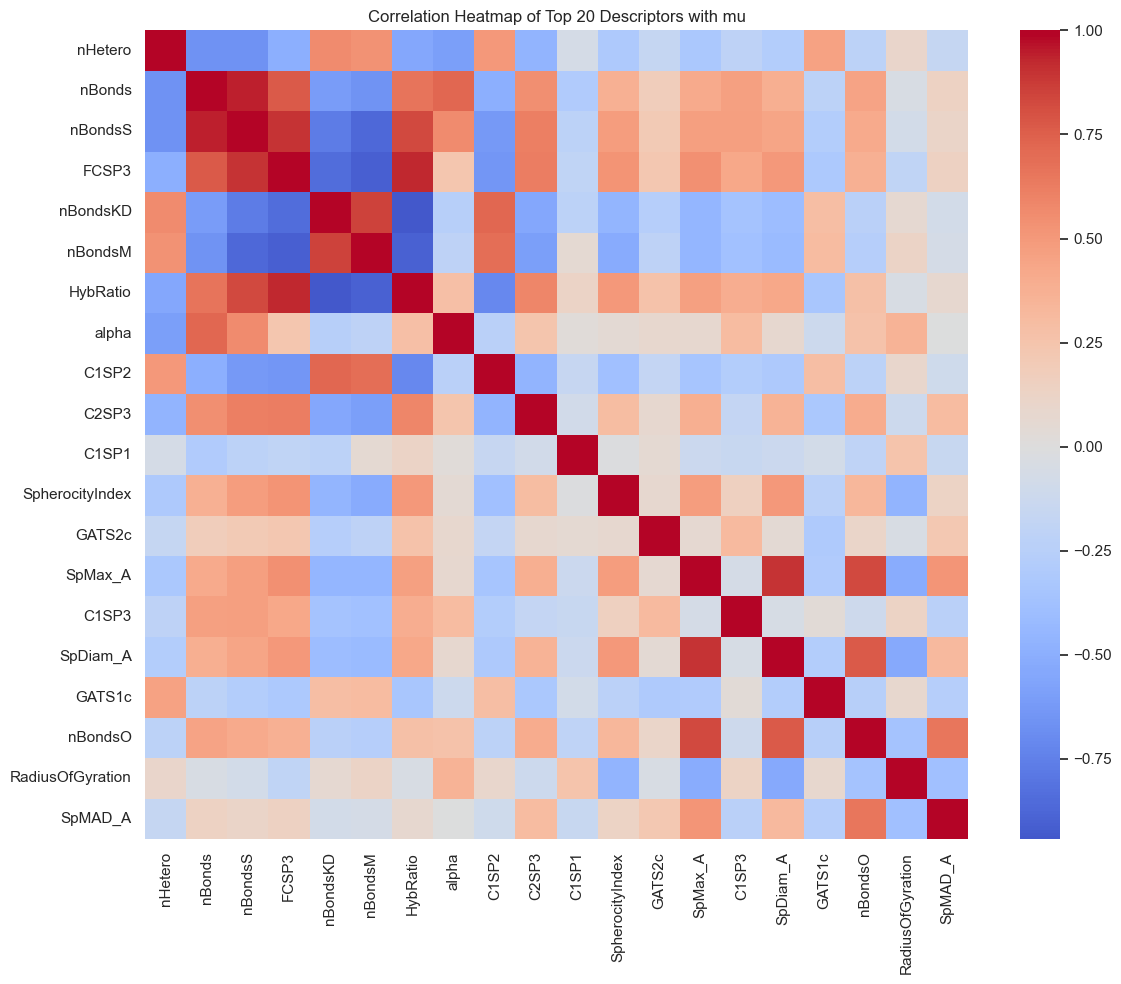

In [10]:
# Pairwise Correlation Heatmap (Top Descriptors)
corrs = df[desc_cols].corrwith(df["mu"]).abs().sort_values(ascending=False)
top_corr_features = corrs.head(20).index

plt.figure(figsize=(12, 10))
sns.heatmap(df[top_corr_features].corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Top 20 Descriptors with mu")
plt.tight_layout()
plt.savefig("../results/plots/heatmap_top20_mu_correlated_descriptors.png", dpi=300)
plt.show()

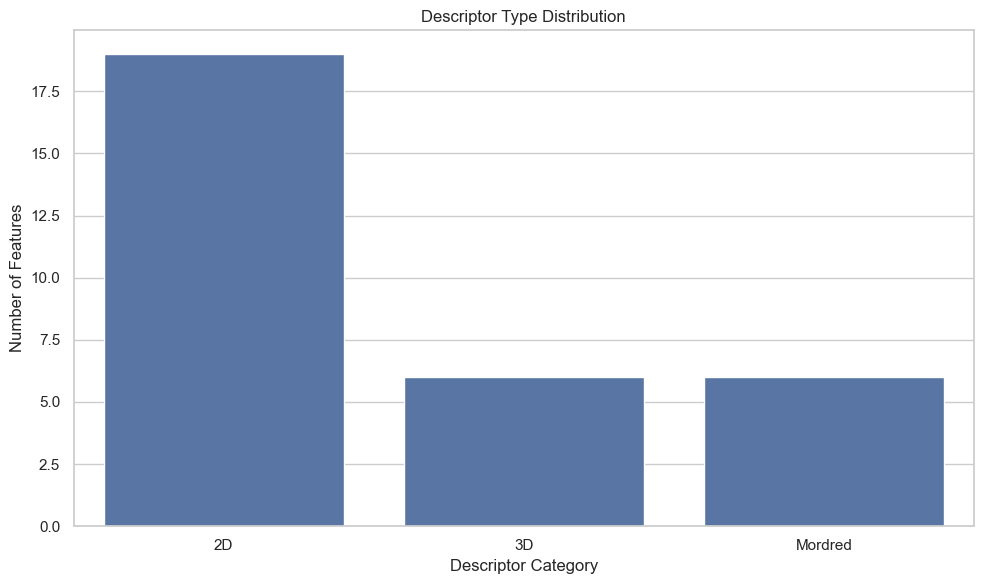

In [11]:
#Distribution of Descriptor Types
def classify_descriptor(colname):
    if colname in ["RadiusOfGyration", "PMI1", "PMI2", "Asphericity", "SpherocityIndex", "NPR2"]:
        return "3D"
    elif colname.startswith("Sp") or colname.startswith("VE"):
        return "Mordred"
    else:
        return "2D"

desc_types = pd.Series(desc_cols).apply(classify_descriptor)
desc_type_counts = desc_types.value_counts()

plt.figure()
sns.barplot(x=desc_type_counts.index, y=desc_type_counts.values)
plt.title("Descriptor Type Distribution")
plt.xlabel("Descriptor Category")
plt.ylabel("Number of Features")
plt.tight_layout()
plt.savefig("../results/plots/barplot_descriptor_type_distribution.png", dpi=300)
plt.show()